Sports Image Classification using Deep Learning
=============================================

This TensorFlow/Keras implementation classifies images into 100 different sports categories 
using transfer learning with EfficientNetB0. The model achieves 98% test accuracy through:

Key Features:
- Transfer learning from ImageNet-pre-trained EfficientNetB0
- Data augmentation to prevent overfitting
- Custom classification head with dropout regularization
- Learning rate scheduling and early stopping

Dataset:
- 13,492 training images (100 classes)
- 500 validation images
- 500 test images

Performance:
- 98% test accuracy
- 0.07 test loss
- Balanced precision/recall across all classes

Author: Anvarbek kuziboev
Date: 20/04/2025 

### I am checking if my dataset loaded accordingly

In [74]:
import os

# iam validating the path
print("Train exists:", os.path.exists('../dataset/train'))
print("Valid exists:", os.path.exists('../dataset/valid'))
print("Test exists:", os.path.exists('../dataset/test'))

# iam creating sample

print("Train subdirectories:", os.listdir('../dataset/train'))

Train exists: True
Valid exists: True
Test exists: True
Train subdirectories: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole danc

### I am importing libraries

In [75]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

### Data Loading

In [76]:
train_set = '../dataset/train'
val_set = '../dataset/valid'
test_set = '../dataset/test'



### Exploratory Data Analysis (EDA)

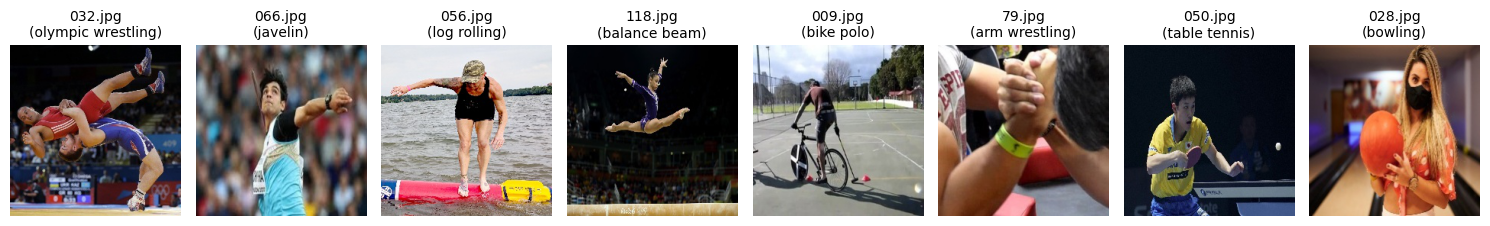

In [77]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define your dataset path
main_folder = '../dataset/train'
num_images = 8

# Get subfolders (each subfolder represents a class)
subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
random.shuffle(subfolders)

# Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 10))

# Loop through selected subfolders and show one image per class
for i, subfolder in enumerate(subfolders[:num_images]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)
    image_path = image_paths[0]

    # Open and display image
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path) + f"\n({os.path.basename(subfolder)})", fontsize=10)

plt.tight_layout()
plt.show()


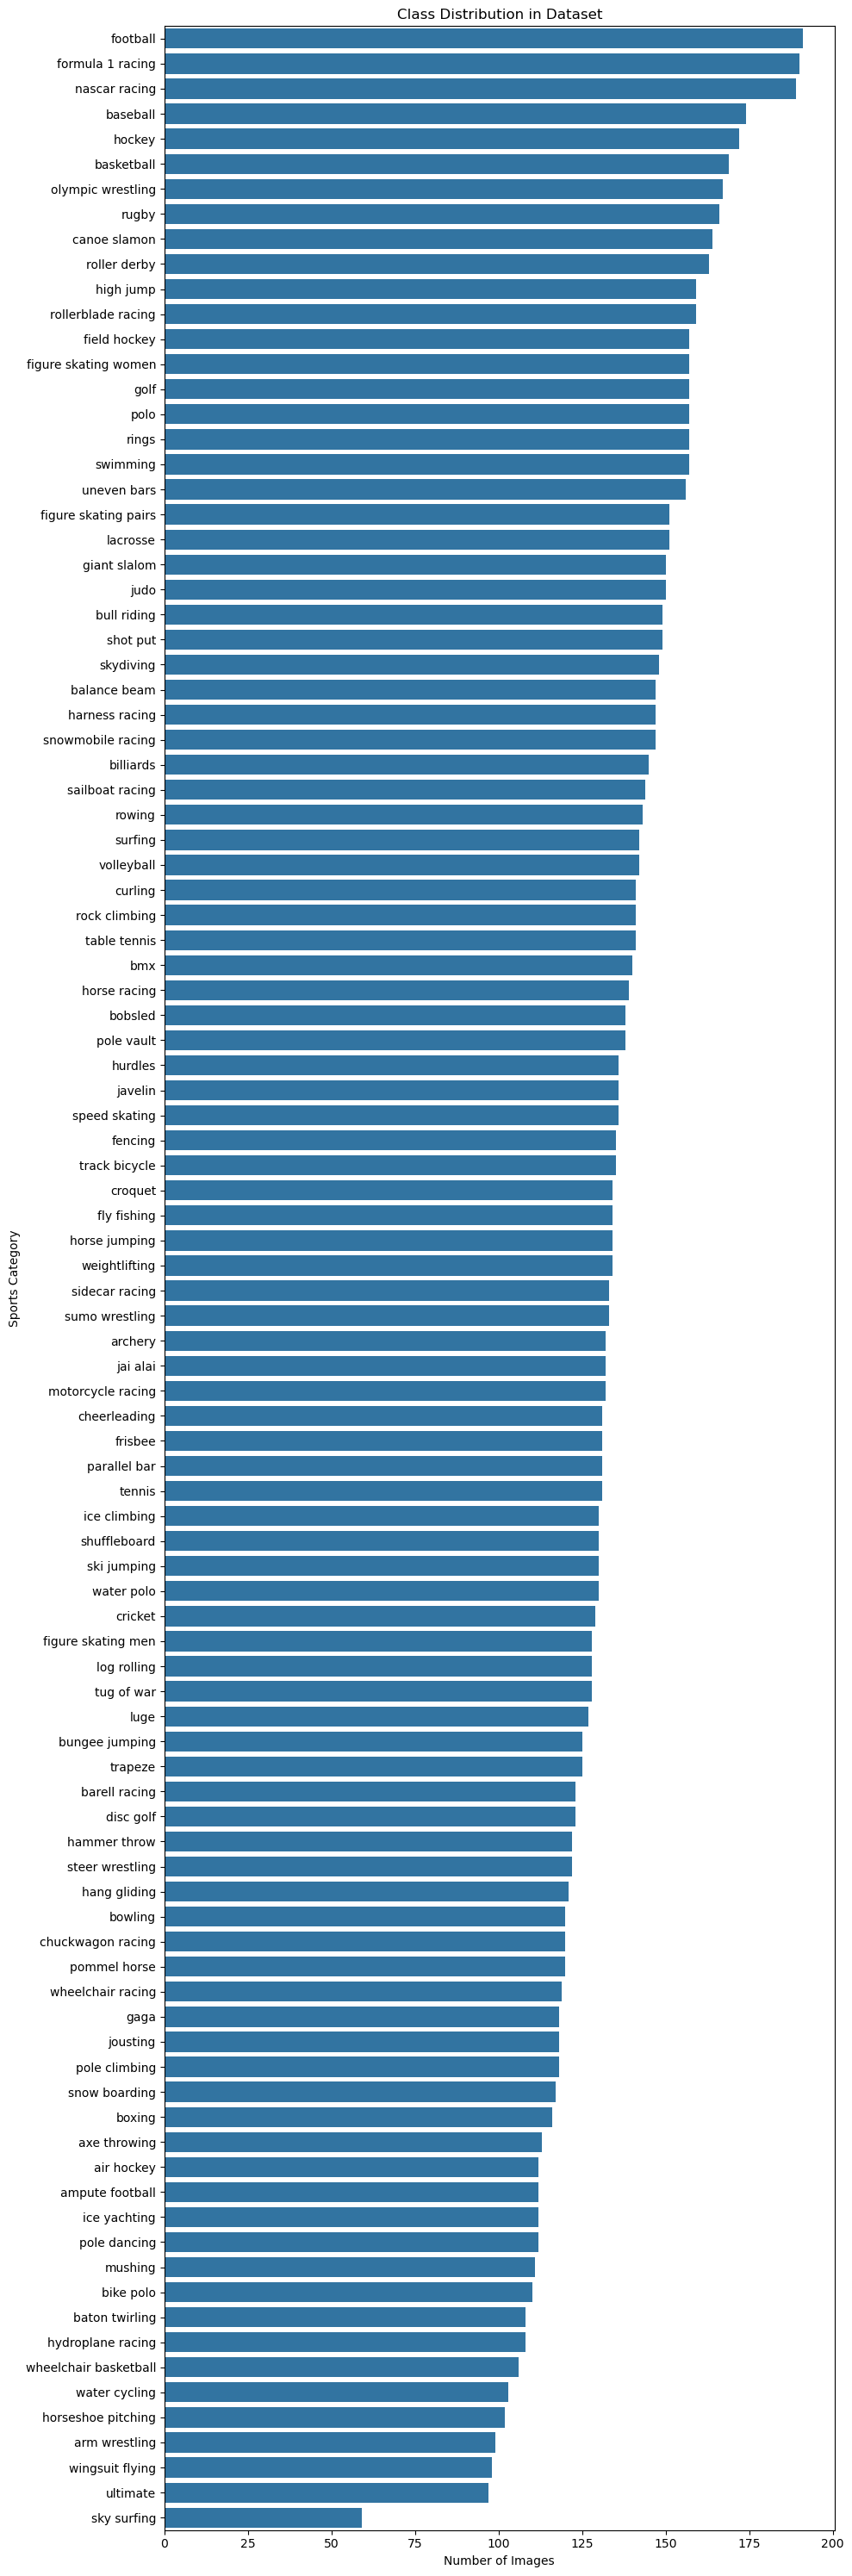

In [79]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort by number of images 
class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(10, 30)) 
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()))
plt.title("Class Distribution in Dataset")
plt.xlabel("Number of Images")
plt.ylabel("Sports Category")
plt.tight_layout()
plt.show()

### I am creating an ImageDataGenerator for Training/Validating/Testing

In [80]:
# Data augmentation setup for training
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Loading training dataset with augmentation
train_dg = train_datagen.flow_from_directory(
    train_set,
    class_mode="categorical",
    target_size=(299, 299),
    batch_size=128,
    shuffle=True,
    seed=42
)




Found 13492 images belonging to 100 classes.


In [82]:
# Data generator for validation set 
val_datagen = ImageDataGenerator()

# Feeding validation images from directory
validation_dg = val_datagen.flow_from_directory(
    directory=val_set,
    class_mode="categorical",
    target_size=(299, 299),
    batch_size=128,
    shuffle=False,
    seed=42
)


Found 500 images belonging to 100 classes.


In [83]:
# Setup for loading the test dataset
testing_dg = val_datagen.flow_from_directory(
    directory=test_set,
    class_mode="categorical",
    target_size=(299, 299),
    batch_size=128,
    shuffle=False,
    seed=42
)


Found 500 images belonging to 100 classes.


### Model training , I am going to use EfficientNetB0 model 

In [86]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# Initialize EfficientNetB0 backbone with pretrained weights and no top classifier
feature_extractor = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(229, 229, 3)
)

for layer in feature_extractor.layers:
    layer.trainable = False

head = feature_extractor.output
head = GlobalAveragePooling2D()(head)
head = Dropout(0.25)(head)
output_layer = Dense(100, activation="softmax")(head) 
# Final model construction
model = Model(inputs=feature_extractor.input, outputs=output_layer)


In [87]:
opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [88]:
history = model.fit(
      train_dg,
      epochs=20,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", 
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/20
106/106 [==============================] - 521s 5s/step - loss: 1.1506 - accuracy: 0.7252 - val_loss: 0.2893 - val_accuracy: 0.9260 - lr: 0.0050
Epoch 2/20
106/106 [==============================] - 503s 5s/step - loss: 0.3890 - accuracy: 0.8974 - val_loss: 0.2065 - val_accuracy: 0.9400 - lr: 0.0050
Epoch 3/20
106/106 [==============================] - 500s 5s/step - loss: 0.2952 - accuracy: 0.9182 - val_loss: 0.1652 - val_accuracy: 0.9460 - lr: 0.0050
Epoch 4/20
106/106 [==============================] - 486s 5s/step - loss: 0.2363 - accuracy: 0.9338 - val_loss: 0.1517 - val_accuracy: 0.9480 - lr: 0.0050
Epoch 5/20
106/106 [==============================] - 516s 5s/step - loss: 0.1998 - accuracy: 0.9437 - val_loss: 0.1584 - val_accuracy: 0.9600 - lr: 0.0050
Epoch 6/20
106/106 [==============================] - 515s 5s/step - loss: 0.1680 - accuracy: 0.9515 - val_loss: 0.1410 - val_accuracy: 0.9560 - lr: 0.0050
Epoch 7/20
106/106 [==============================] - 542s 5s/st

### I am going to plot metrics

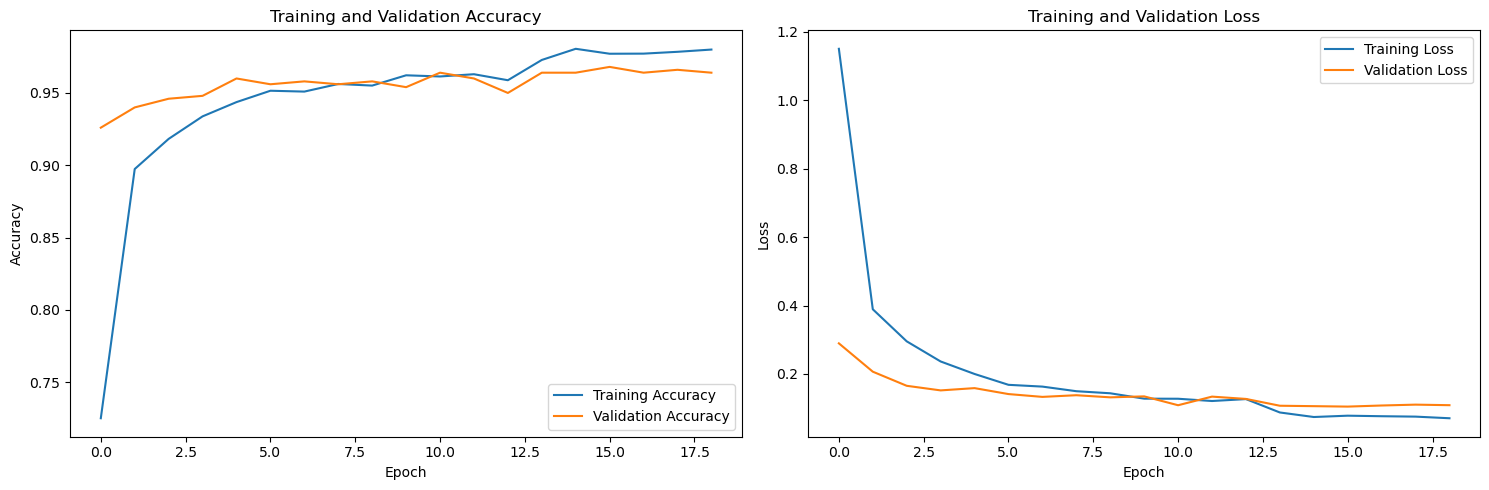

In [92]:
#Plot Training History (Accuracy/Loss)
plt.figure(figsize=(15, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

### Model evaluation

In [95]:
#Evaluate Model on Test Data
test_results = model.evaluate(testing_dg, verbose=0)
print("\nTest Metrics:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")


Test Metrics:
Loss: 0.0652
Accuracy: 0.9800


In [98]:
#Generate Predictions
y_true = testing_dg.classes
y_pred = np.argmax(model.predict(testing_dg), axis=1)

#Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=list(testing_dg.class_indices.keys())
))

4/4 [==============================] - 10s 2s/step

Classification Report:
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      1.00      1.00         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00      1.00

### Confusion matrix

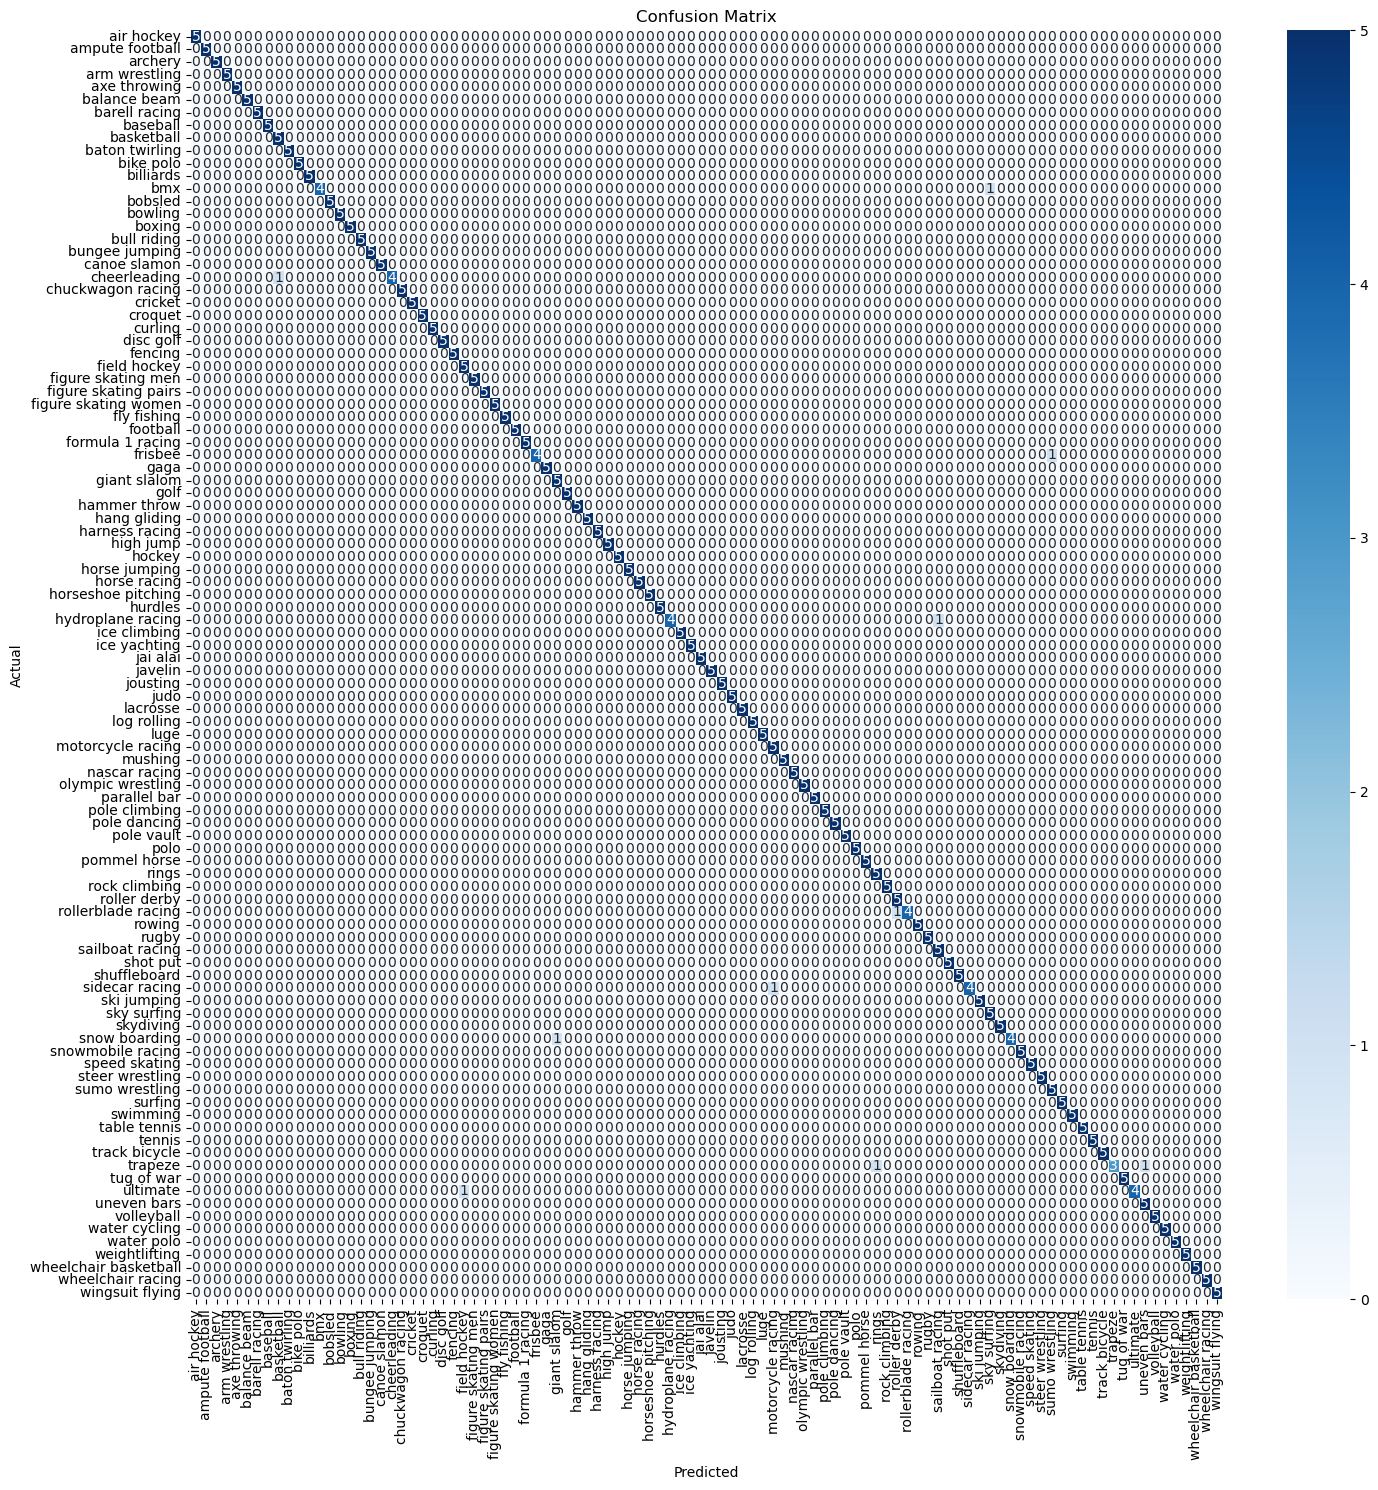

In [102]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=testing_dg.class_indices.keys(),
                yticklabels=testing_dg.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()